# Analyze A/B Test Results

## Project 2: Practical Statistics 

## Table of Contents

    -Introduction
    -Part I - Probability
    -Part II - A/B Test
    -Part III - Regression
    -Conclusions

## Introduction

A/B Tests are very commonly performed by data analysts to interpret and examine given datasets. From this Udacity Data Analysis project, we are trying to analyze datasets from an e-commerce new web page A/B test results. Our goal is to help the company understand if they should implement new web page, keep the old page, or perhaps run the experiment longer to make their decision.

## Part 1 - Probability

By comupting the probabilities for converting rate regardless of page, we will be able to analyze if one page or the other led to more conversions.

Let's get started by importing necessary libraries.

In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#use seed = 42 to re-generate the results in this project 
random.seed(42)

### Data Wrangling 

In this step, we will read in the _ab_data.csv_ data and store it in df. We will be also taking a look at overall dataset.

In [13]:
# read in dataset and display top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
# number of rows 
df.shape

(294478, 5)

In [14]:
# number of unique users
df.user_id.nunique()

290584

In [20]:
# proportion of users converted
df.converted.mean()

0.11965919355605512

In [22]:
# number of times the new_page and treatment don't line up
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

In [18]:
# rows of missing value
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## Data Cleaning

Due to incorrect assginemtn of `group` and `landing_page`, a new dataframe `df2` is created to store records for analyzing A/B test results

In [24]:
# correctly assign group and landing_page to df2
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [25]:
# double check all of the correct rows  were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [26]:
# check df2 info
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [27]:
# number of unique users in df2
df2.user_id.nunique()

290584

In [28]:
# look for duplicate user id
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

In [29]:
# row information for repeat user id
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [30]:
# remove duplicate from df2
df2.drop_duplicates('user_id', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [33]:
# quick check of df2
df2.shape

(290584, 5)

## Exploratory Data Analysis 

We are looking into the probability of an individual converting regardless of the group the use is in. In this step, we will see if there is any statistical significance is shown.

In [35]:
# probability of a user converting regardless of the user's group
df2.converted.mean()

0.11959708724499628

In [36]:
# probability of a user converting in control group
df2.query("group == 'control'").converted.mean()

0.1203863045004612

In [37]:
# probability of a user converting in treatment group
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

In [38]:
# propbability of a user receiving a new page
df2.query("landing_page == 'new_page'").shape[0] / df2.landing_page.shape[0]

0.5000619442226688

#### The probability of an user receiving a new page is about 50%, which means an user will receive old page at 50% as well.

#### The probability of conversion from the `control` group is approximate 12.4% and 11.88% from the `treatment` group, which there is only a very slight difference.

#### Hence, it indicates the new page is not improving the converting rate.

# Part 2: A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, we may need to ask two questions which are hard to answer.

#### Should the test stop as soon as one page is considered significantly better than another?
#### Should it need to happen consistently for a certain amount of time, and how long?

For now, we just need to make decision based on all data provided. 


## Hypothesis

Assuption: Old page is better in terms of converting rate unless the new page proves to be definitely better at a Type I error rate of 5%. The hypotheses are stated in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages below.

#### Null Hypothesis: The probability of old page better than new page is greater or equal to probability of new page.
#### Alternative Hypothesis: The probability of new page being better than new page is less than that of a new page.


$H_{A}$ : $P_{old}$ - $P_{new}$ $<$ $0$


## Sampling distribution for the difference in convert rates

We will use a sample size for each page equal to the ones in `ab_data.csv`.

In [43]:
# convert rate for new page
p_new = df2.converted.mean()
p_new


0.11959708724499628

In [45]:
# convert rate for old page
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [49]:
# sample size of new page
n_new = df2[df2.group == 'treatment'].count()[0]
n_new

145310

In [50]:
# sample size of old page
n_old = df2[df2.group == 'control'].count()[0]
n_old

145274

In [53]:
# simulation of n_new outcomes with a convert rate of null_p_new
new_page_converted = np.random.binomial(1,p_new,n_new) 
new_page_converted.mean()

0.12048723418897529

In [56]:
# simulation of n_old outcomes with a convert rate of null_p_old
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.12020044880708179

In [58]:
#simulation of difference in convert rate between groups
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.00028678538189350067

In [59]:
# sampling distribution for the difference in the convert rates between the two pages

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)  # bootstrapping
    old_page_converted = np.random.binomial(1,p_old,n_old) # bootstrapping
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

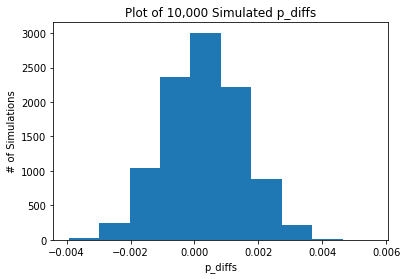

In [61]:
# histgram plot of 10000 differences in convert rates between groups
plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

In [62]:
# convert p_diffs into a numpy array
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00285394, -0.00060811,  0.00204191, ...,  0.00182856,
        0.00222092, -0.00049095])

In [63]:
# compute actual difference observed in the csv dataset
act_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
act_diffs

-0.0015782389853555567

## p-Value 

In [64]:
# compute the proportion of p_diffs greater than act_diff
(p_diffs > act_diffs).mean()

0.9398

#### From the previous computation, we know p-Value is 0.9398. Either to statistically interpret our hypotheses, we need to examine the p-Value, which having a large p-Value that we can confidently say that we fail to reject null hypothesis.
#### That is, old pages are the same or slightly better than the new pages.

## Two-sample Z-test

In [68]:
# use built-in statsmodels.api to achieve the same result

import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [69]:
# use stats.proportions_ztest to compute your test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [70]:
#import the norm function to compute the significance of z-score
from scipy.stats import norm

norm.cdf(z_score)

0.9050583127590245

In [71]:
#critical value at 95% confidence interval
norm.ppf(1-(0.05/2))

1.959963984540054

#### z-score represents the number of standard deviations by which the value of a raw score is above or below the mean value .
#### From the above computation results, z-score is very close to p-value, which both are 90%,which neither do not exceed critical value (95%), so there is no statistical evidence to reject the null hypothesis.

# Part 3: Regression

We have computed the results by using A/B test in previous steps, in this step, a logistic regression is also used to analyze the A/B test results. To commecne, we need to create `intercept` and `ab_page` columns.

In [73]:
# add an intercept
df2['intercept'] = 1

# add a dummy column to df2
df2[['ab_page2', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page2', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [74]:
# use statsmodel to import regression model
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [75]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:21:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### The p-Value obtained from logistic regression for `ab_page` is 0.19,  which is drastically lower than we got from A/B test which is approximately 0.9. The reason for such huge difference is because the null and the alternative hypotheses are not the same in each part.
The null and alternative hypotheses for logistic regression model are listed below:
$$ H_{0}: p_{old} - p_{new} = 0$$$$ H_{0}: p_{old} - p_{new} \neq 0$$

## Does Country has an impact on conversion 

In [76]:
# read file and join the dfs
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [77]:
# quick check
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [79]:
# create dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0


In [81]:
# results summary
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 05 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:21:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [82]:
1/(np.exp(-0.0408)), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

# Conclusions

In this project, we have examined and analyzed data set from an e-commerce whether or not they should implement new web page, keep the old page or perhaps run the experiment longer with the approaches below:

    -Probability approach
    -A/B test
    -Regression approach

### Probability Approach

Based on probability approach, an individual receiving the new page is 0.5001, which means an individual received old page or new page is almost the same.

### A/B Test Approach

According to A/B test, it is not recommended to implement new page because the converting rate for old page is determined to be euqal or larger than the converting rate for the new page.


### Logistic Regression Approach

Even though the p-value generated from logistic regression is different from A/B test; however, the findings from logistic regression also failed to reject null hypothesis. We also examined whether or not country has an impact on converting rate, the results gives a similar suugestion that country has no impact on the converting rate.